In [1]:
using ComputationalHeatTransfer

In [2]:
# using Plots
using LaTeXStrings

In [3]:
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using Plots
pyplot()

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:1369


Plots.PyPlotBackend()

In [58]:
cd(dirname(pwd()))
cd("src") 

includet("OneDOHP.jl")
using ..OneDOHP

### Physical parameters

In [5]:
ρ = 2702;
c = 9.03e02;
k = 2.37e02;
d = 1e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2702.0, 903.0, 237.0, 9.713488962279695e-5, 0.001)

### Geometry parameters

In [6]:
Lx = 0.1524
Ly = 0.0648;
inch = 2.54e-2;

In [7]:
xlim = (-Lx/2,Lx/2)
ylim = (-Ly/2,Ly/2)
# Δx, Δt = setstepsizes(params.α,gridPe=0.1,fourier=200.0)
Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000.0)
Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000000.0)

(0.00048567444811398473, 0.23587966955082365)

### Set up the evaporator and condenser

In [8]:
eb = Rectangle(inch,inch,1.5*Δx)
Te = RigidTransform((0.0,-0.0),0.0)
Te(eb)
cb1 = Rectangle(0.5,0.5,1.5*Δx)
Tc = RigidTransform((0.5+0.5Lx-inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5,0.5,1.5*Δx)
Tc = RigidTransform((0.5-(0.5Lx-inch),-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 2000.0
Tc = -30.0

eparams = PrescribedHeatFluxRegion(qe,eb);
cparams = [PrescribedHeatModelRegion(hc,Tc,cb1);PrescribedHeatModelRegion(-hc,Tc,cb2)];

### Set up the OHP

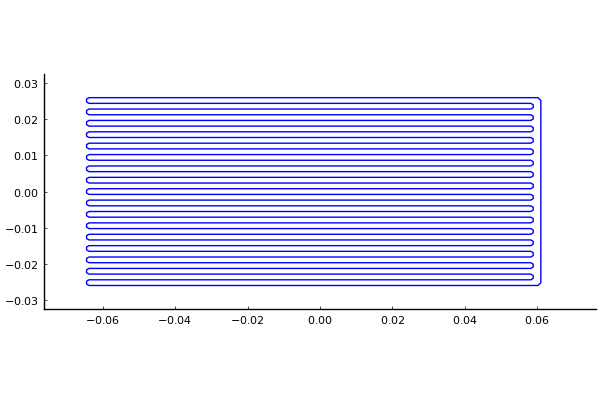

In [9]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = Ly*0.8
height = Lx*0.8
gap = 2*d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim)


In [10]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [11]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qflux=eparams,qmodel=cparams,qline=ohpgeom)
# sys = HeatConduction(params,Δx,xlim,ylim,Δt,qflux=eparams,qmodel=cparams)
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Unbounded Heat conduction system on a grid of size 320 x 140 and 0 static immersed points


#### Initialize state, and create the integrator

In [12]:
u0 = newstate(sys)
# tspan = (0.0,1.0)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 320, ny = 140) cell grid of type Float64 data
  Number of Primal nodes: (nx = 319, ny = 139), Float64[])

### Set up values for the OHP heat flux per unit length and advance the solution

In [13]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 320 x 140 and 0 static immersed points


In [14]:
@time step!(integrator,30.0)
maximum(integrator.u[:])

 51.743591 seconds (5.25 M allocations: 6.800 GiB, 2.58% gc time)


84.96170422509593

In [15]:
integrator.t

30.000000000000156

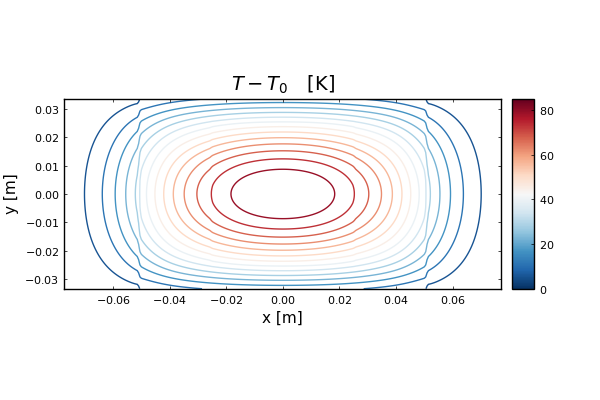

In [17]:
plot(temperature(integrator),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T - T_0 \quad [\mathrm{K}]")
# plot!(ohp,fillalpha=0,line_z=qtmp)

In [18]:
maximum(integrator.u[:])

84.96170422509593

### Plot the temperature along the OHP channel

In [19]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

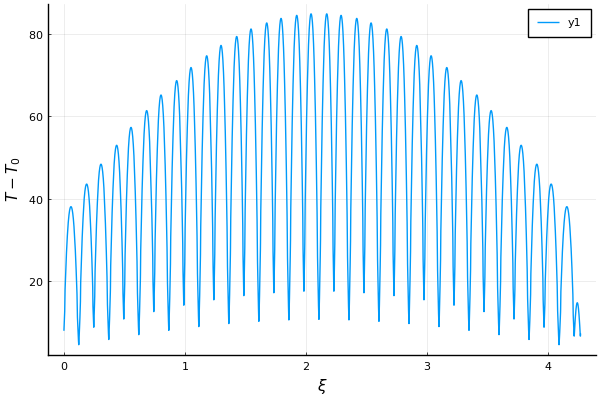

In [20]:
plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [389]:
T0 = 273.15
nondi_Q_to_Q = 8.52e01
t_to_nondi_t = 3.42e-01
function di_T_to_nondi_T(di_T;T0=273.15) 
    
    (di_T+T0)/T0
    
end

di_T_to_nondi_T (generic function with 1 method)

In [390]:
    ω = sqrt(1.68e003);
    ℘L = 6.2e004;
    k = 115e-003

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
    Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
#     Hₗ   =  2.57e004; # liquid wall heat transfer coeffcient
    Hδ  = 7.34e002;


In [391]:
    
    d = 6.56e-3 # dimensionless diameter
    L = 35.0  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    closedornot = true

true

In [402]:
    nucleatenum = 32
    Xstations = sort(rand(nucleatenum).*L);
#     boilingΔt = 0.05

In [403]:
tube = Tube(d,L,L2D,angle,closedornot);

In [404]:
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [405]:
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [406]:
numofX=16
Xps = sort(rand(2*numofX).*L);
Xp1s = Xps[1:2:end];
Xp2s = Xps[2:2:end];

dXdt0 = map(tuple,0*Xp1s,0*Xp2s)
X0 = map(tuple,Xp1s,Xp2s);


In [407]:
N=numpts(ohp)
# X0 = [(L/4, L*3/4)]
# dXdt0 = [(0.0,0.0)]
ρ = 214.6
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [408]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
Hδ = 7.34e2
P = 0*Xp1s .+ 1.0;
δ = 0*Xp1s .+ 2.86e-02;
vapors=Vapor(γ,Hδ,P,δ);

In [409]:
α = 0 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [410]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall);

In [411]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

## construct state vector U

In [412]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [413]:
# cb_boiling =  ContinuousCallback(boiling_condition,boiling_affect!)
cb_boiling =  PeriodicCallback(boiling_affect!,0.005)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

## solve OHP

In [414]:
pp = getcurrentsys(integrator_tube.sol[end],integrator_tube.p)

pp.liquid.Xp

3-element Array{Tuple{Float64,Float64},1}:
 (28.832076952802563, 5.583264860017483)
 (6.29854941578584, 6.674251360414015)
 (8.421471433512597, 10.982969088792796)

In [ ]:
# tstep=1e-4*t_to_nondi_t
tstep=5e-5

p = sys0
tspan = (0.0, 0.1);
prob = ODEProblem(ODE_innertube, u, tspan, p)

integrator_tube = init(prob, Euler(), dt=tstep, callback=cb_merging);

@time solve!(integrator_tube);


  0.001380 seconds (743 allocations: 757.219 KiB)
  0.001233 seconds (743 allocations: 757.219 KiB)
  0.002083 seconds (743 allocations: 757.219 KiB)
  0.001561 seconds (743 allocations: 757.219 KiB)
  0.001263 seconds (743 allocations: 757.219 KiB)
  0.001355 seconds (742 allocations: 755.094 KiB)
  0.001453 seconds (743 allocations: 757.219 KiB)
  0.001392 seconds (742 allocations: 755.094 KiB)
  0.001428 seconds (743 allocations: 757.219 KiB)
  0.001478 seconds (743 allocations: 757.219 KiB)
  0.001862 seconds (743 allocations: 757.219 KiB)
  0.001796 seconds (742 allocations: 755.094 KiB)
  0.001552 seconds (742 allocations: 755.094 KiB)
  0.002183 seconds (742 allocations: 755.094 KiB)
  0.001882 seconds (743 allocations: 757.219 KiB)
  0.001869 seconds (743 allocations: 757.219 KiB)
  0.002422 seconds (743 allocations: 757.219 KiB)
  0.002047 seconds (743 allocations: 757.219 KiB)
  0.002565 seconds (743 allocations: 757.219 KiB)
  0.002095 seconds (743 allocations: 757.219 KiB)


  0.002437 seconds (743 allocations: 757.219 KiB)
  0.003046 seconds (702 allocations: 753.547 KiB)
  0.002249 seconds (701 allocations: 751.422 KiB)
  0.002421 seconds (702 allocations: 753.547 KiB)
  0.002359 seconds (702 allocations: 753.547 KiB)
  0.002134 seconds (701 allocations: 751.422 KiB)
  0.002204 seconds (701 allocations: 751.422 KiB)
  0.002375 seconds (701 allocations: 751.422 KiB)
  0.002333 seconds (702 allocations: 753.547 KiB)
  0.002352 seconds (701 allocations: 751.422 KiB)
  0.003553 seconds (701 allocations: 751.422 KiB)
  0.002312 seconds (702 allocations: 753.547 KiB)
  0.002410 seconds (702 allocations: 753.547 KiB)
  0.004569 seconds (702 allocations: 753.547 KiB)
  0.002207 seconds (702 allocations: 753.547 KiB)
  0.002257 seconds (701 allocations: 751.422 KiB)
  0.002351 seconds (701 allocations: 751.422 KiB)
  0.001975 seconds (702 allocations: 753.547 KiB)
  0.002308 seconds (702 allocations: 753.547 KiB)
  0.002247 seconds (702 allocations: 753.547 KiB)


  0.002025 seconds (702 allocations: 753.547 KiB)
  0.001335 seconds (701 allocations: 751.422 KiB)
  0.001396 seconds (702 allocations: 753.547 KiB)
  0.001428 seconds (702 allocations: 753.547 KiB)
  0.001349 seconds (701 allocations: 751.422 KiB)
  0.001336 seconds (702 allocations: 753.547 KiB)
  0.001339 seconds (701 allocations: 751.422 KiB)
  0.001973 seconds (702 allocations: 753.547 KiB)
  0.001710 seconds (702 allocations: 753.547 KiB)
  0.001340 seconds (701 allocations: 751.422 KiB)
  0.002639 seconds (702 allocations: 753.547 KiB)
  0.001437 seconds (702 allocations: 753.547 KiB)
  0.002354 seconds (702 allocations: 753.547 KiB)
  0.001583 seconds (702 allocations: 753.547 KiB)
  0.002312 seconds (702 allocations: 753.547 KiB)
  0.001392 seconds (701 allocations: 751.422 KiB)
  0.001399 seconds (702 allocations: 753.547 KiB)
  0.001355 seconds (702 allocations: 753.547 KiB)
  0.001448 seconds (702 allocations: 753.547 KiB)
  0.001410 seconds (702 allocations: 753.547 KiB)


In [478]:
sol = integrator_tube.sol
sysfinal = getcurrentsys.(sol.u,[sys0]);

In [454]:
integrator_tube.sol

retcode: Success
Interpolation: 3rd order Hermite
t: 77-element Array{Float64,1}:
 0.0
 3.4999348468399225e-5
 4.825978614842796e-5
 7.640200663811273e-5
 0.00010126885743931151
 0.00013484699759284654
 0.00017108755521791667
 0.0002160920898435912
 0.00026699254547913064
 0.00032456507808222636
 0.0003967669769938245
 0.00047384332381124686
 0.0005673530234703259
 ⋮
 0.004667373204923871
 0.004687422324852932
 0.004706301523436509
 0.004730970337603913
 0.004759475929827167
 0.004795138347898663
 0.0048351051505202795
 0.00488516286720417
 0.004945073101886475
 0.004983351286605306
 0.005
 0.005
u: 77-element Array{Array{Float64,1},1}:
 [0.03366753013249735, 0.4275227139744875, 0.9307351860610036, 1.291637269874063, 2.01899318899856, 5.087953452695924, 5.8039181853472, 7.57414298854335, 8.371966025873203, 8.508032918877554  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.03366502957241392, 0.42752021341440405, 0.930734348324374, 1.2916364321374334, 2.0189934306246493, 5.08795

In [476]:
integrator_tube.sol

retcode: Success
Interpolation: 3rd order Hermite
t: 17-element Array{Float64,1}:
 0.0
 3.4999348468399225e-5
 4.825978614842796e-5
 7.640200663811273e-5
 0.00010126885743931151
 0.00013484699759284654
 0.00017108755521791667
 0.0002160920898435912
 0.00026699254547913064
 0.00032456507808222636
 0.0003967669769938245
 0.00047384332381124686
 0.0005673530234703259
 0.0006891542512353409
 0.0008123018239089923
 0.0009475428813234789
 0.001
u: 17-element Array{Array{Float64,1},1}:
 [0.03366753013249735, 0.4275227139744875, 0.9307351860610036, 1.291637269874063, 2.01899318899856, 5.087953452695924, 5.8039181853472, 7.57414298854335, 8.371966025873203, 8.508032918877554  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.03366502957241392, 0.42752021341440405, 0.930734348324374, 1.2916364321374334, 2.0189934306246493, 5.087953694322014, 5.803918272694165, 7.574143075890316, 8.371964077469407, 8.508030970473758  …  1.0000195140461523, 1.000019488271272, 1.000019439184346, 1.0000193668

In [526]:
@time step!(integrator_tube)

  0.001122 seconds (223 allocations: 711.016 KiB)
  0.000922 seconds (223 allocations: 711.016 KiB)
  0.001587 seconds (224 allocations: 712.156 KiB)
  0.000971 seconds (223 allocations: 711.016 KiB)
  0.001212 seconds (223 allocations: 711.016 KiB)
  0.000888 seconds (224 allocations: 712.156 KiB)
  0.069781 seconds (5.34 k allocations: 14.545 MiB)


In [448]:
sysfinal

77-element Array{PHPSystem,1}:
 PHPSystem(Tube(0.00656, 35.0, 1.0, 0.0, true), Evaporator([(1.0, 3.0)], [0.0]), Condenser(1.0, [(0.0, 1.0), (3.0, 4.0)], 0.0), Liquid(1600.0, 214.6, 40.98780306383839, 62000.0, [(0.03366753013249735, 0.4275227139744875), (0.9307351860610036, 1.291637269874063), (2.01899318899856, 5.087953452695924), (5.8039181853472, 7.57414298854335), (8.371966025873203, 8.508032918877554), (10.614306212228664, 12.040639731112206), (12.608727681095125, 12.856387056334373), (13.712244826747039, 15.759132050999645), (16.538810401632844, 17.472590231594367), (19.007755548320283, 19.158055123682704), (21.376632445999828, 24.19672251590352), (25.542204403249272, 26.207993891566918), (26.550477426742496, 27.599075540817868), (30.07543687360664, 30.6227679517167), (31.757660375849802, 34.69895970256039), (34.7016970296272, 34.8433557122854)], [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.

## combine inner tube and plate together

In [40]:
tspan = (0.0, 0.01);

In [41]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 320, ny = 140) cell grid of type Float64 data
  Number of Primal nodes: (nx = 319, ny = 139), Float64[])

In [42]:
integrator_tube = init(prob, RK4(),save_everystep=false, callback=cb_merging);

LoadError: [91mUndefVarError: cb_merging not defined[39m

In [43]:
@time step!(integrator_plate,tstep, true)

  0.165228 seconds (3.47 k allocations: 22.561 MiB)


In [44]:
@time step!(integrator_tube, tstep*t_to_nondi_t, true)

LoadError: [91mUndefVarError: integrator_tube not defined[39m

In [45]:
# currentsys = getcurrentsys(integrator_tube.u,sys0)
# for t in tspan[1]:tstep:tspan[2]
    
    

#     @time currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
#     @time currentsys = getcurrentsys(integrator_tube.u,currentsys)
    
    
#     nondi_qtmp = sys_to_heatflux(currentsys)
#     qtmp = nondi_Q_to_Q*nondi_qtmp
#     set_linesource_strength!(sys,qtmp)
#     @time step!(integrator_plate,tstep, true)


    
#     @time step!(integrator_tube, tstep*t_to_nondi_t, true)

# end

In [46]:
integrator_plate.t

0.0001

In [47]:
sysfinal = [getcurrentsys(integrator_tube.u,sys0)];

LoadError: [91mUndefVarError: integrator_tube not defined[39m

In [48]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

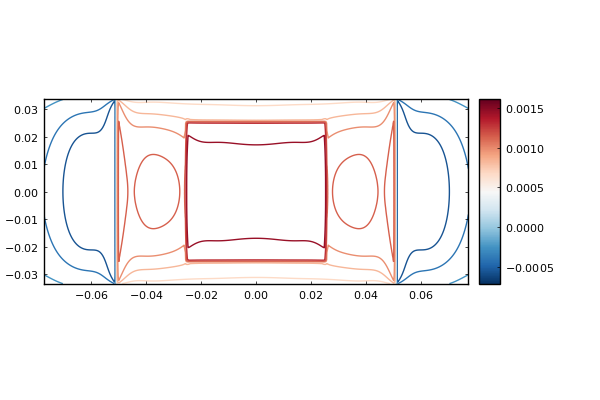

In [49]:
plot(temperature(integrator_plate),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0)
# plot!(ohp,fillalpha=0,line_z=0 .* qtmp)

In [50]:
integrator_tube.sol

LoadError: [91mUndefVarError: integrator_tube not defined[39m

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning:

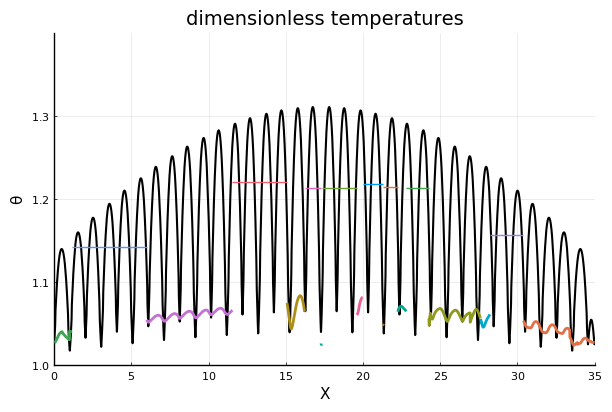

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
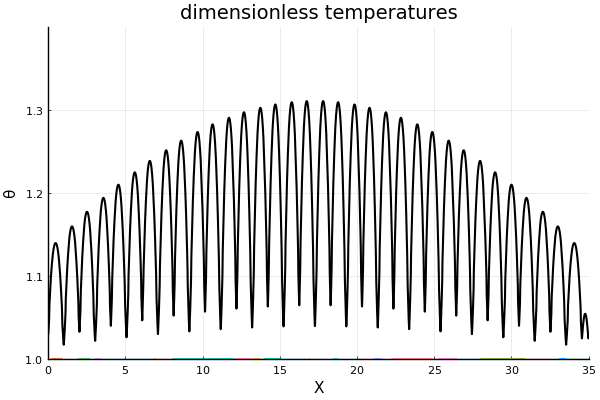

In [128]:
# closed loop plot
@gif for i=1:5:length(sysfinal)
# @gif for i=1:1:80
        
    Xpvapor = getXpvapor(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
    θvapor  = (sysfinal[i].vapor.P).^((γ-1)/γ)
    Xp = sysfinal[i].liquid.Xp
    
    p = plot([sysfinal[i].wall.Xarray],[sysfinal[i].wall.θarray], linewidth=1.5, color = [:black], ylim=(1.0,1.4),legend=:none, labels = "θwall", xlabel="X", ylabel="θ", title=("dimensionless temperatures"),xlim=(0,sysfinal[i].tube.L))
    
    
    j=1
    while j <= length(Xp)
        if Xp[j][end] >= Xp[j][1]
            plot!(p, [sysfinal[i].liquid.Xarrays[j]],[sysfinal[i].liquid.θarrays[j]], linewidth=2, labels = string("θliquid ",j))
            else 
            # find the index at the end
            index = findfirst(x->x <= sysfinal[i].liquid.Xarrays[j][end], sysfinal[i].liquid.Xarrays[j])
            
            plot!(p, [sysfinal[i].liquid.Xarrays[j][1:index-1]],[sysfinal[i].liquid.θarrays[j][1:index-1]], linewidth=2, labels = string("θliquid ",j))
            plot!(p, [sysfinal[i].liquid.Xarrays[j][index:end]],[sysfinal[i].liquid.θarrays[j][index:end]], linewidth=2, labels = string("θliquid ",j))

        end
        
        j += 1
    end

        j=1
    while j <= length(Xpvapor)
        if Xpvapor[j][end] >= Xpvapor[j][1]
            plot!(p,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
            else
            
            plot!(p,[0.0,Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
            plot!(p,[Xpvapor[j][1],L],[θvapor[j]], labels = string("θvapor ",j))

        end
        
        j += 1
    end
    
#     j = 1
#     plot!(p,[0.0,Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
#     plot!(p,[Xpvapor[j][1],L],[θvapor[j]], labels = string("θvapor ",j))
    
#     j = 2
#     while j  <= length(θvapor) 
    
#         plot!(p,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
        
#         j += 1
#     end

#     vline!( p, [collect(0:2:4)], color=[:blue,:red], width=196, alpha=[0.3,0.3,0.3],labels = "")
    
    end 

In [52]:
# @gif for i = 1:5:length(sysfinal)
i=200
    nondi_qtmp = sys_to_heatflux(sysfinal[i])
        qtmp = nondi_Q_to_Q*nondi_qtmp
#         set_linesource_strength!(sys,qtmp)
    plot(sysfinal[i].wall.Xarray,qtmp,ylim=(0.0,8e5))
# end

LoadError: [91mUndefVarError: sysfinal not defined[39m

In [53]:
ohp

Basic pointwise-specified body with 5853 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


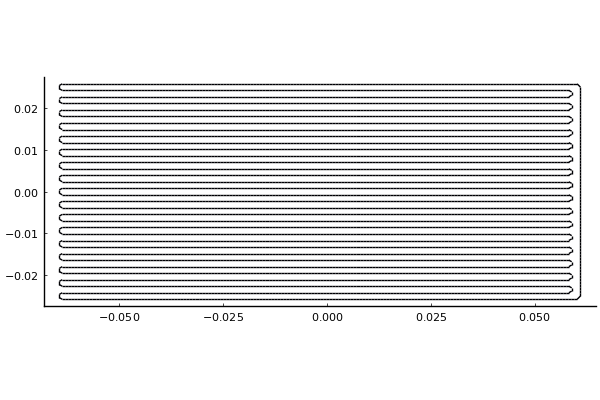

In [54]:
plot(ohp,fillalpha=0,line_z=qtmp)

In [55]:
@gif for i = 1:1000:length(sysfinal)
    nondi_qtmp = sys_to_heatflux(sysfinal[i])
        qtmp = nondi_Q_to_Q*nondi_qtmp
#         set_linesource_strength!(sys,qtmp)
    plot(ohp,fillalpha=0,line_z=qtmp)
end

LoadError: [91mUndefVarError: sysfinal not defined[39m

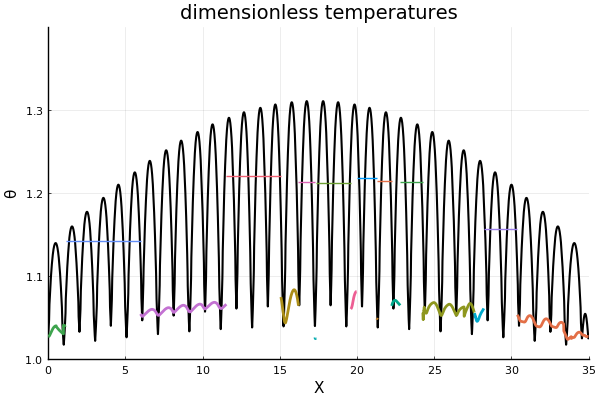

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:5853.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\vVVub\src\utils.jl:102


In [136]:
p

In [139]:
getinsertindex(sysfinal[end].liquid.Xp,sysfinal[end].wall.Xstations[1],sysfinal[end].tube.L)

8

In [185]:
sysfinal[end].wall.Xstations[1]

27.54993612815658

In [195]:
sysfinal[320].liquid.Xp

10-element Array{Tuple{Float64,Float64},1}:
 (33.53958158276225, 1.3008305841929226)
 (6.727585597695215, 12.287503218265726)
 (15.003368564763836, 16.137354318184595)
 (17.167511910320513, 17.212260445160364)
 (19.056166094110722, 19.432866703448415)
 (20.457762158845192, 20.500749567099867)
 (21.459971222453202, 22.013154843826452)
 (23.623986770605146, 27.55083609781533)
 (27.55544834338451, 27.581526779240683)
 (29.897523250201434, 32.88937789052367)